# 9. NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences, text or speech)

Another common term for NLP problems is sequence to sequence problems (seq2seq)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

%matplotlib inline

## Example NLP problems

1. Classification
2. Text Generation
3. Machine Translation
4. Voice Assistants

## Other Sequence Problems

1. one-to-one
2. one-to-many
3. many-to-one
4. many-to-many
5. many-to-many (synchronised)

## What we're going to cover

* Dowloading and preparing a text dataset
* How to prepare text data for modelling (tokenization and embedding)
* Setting up multiple modelling experiments with recurrent neural networks (RNNs)
* Building a text feature extraction model using TensorFlow Hub
* Finding the most wrong prediction examples
* Using a model we've built to make predictions on text from the wild

## NLP inputs and outputs

Is this tweet a disaster or not?

Input                        -> Model -> Disaster/Not Disaster <br>
[batch_size, embedding_size]

Shape = [None, 512]<br>
      Or <br>
Shape = [32, 512]

1. Turn all data into numbers (neural networks can't handle text/natural language)
2. Make sure all of your sequences are the right shape (pad sequences which don't fit)

## Recurrent Neural Network

|Hyperparameter/Layer type|What does it do?|Typical values|
|-------------------------|----------------|--------------|
|Input text(s)|Target texts/sequences you'd like to discover patterns in|Whatever you can represent as text or a sequence|
|Input layer|Takes in target sequence|input_shape = [batch_size, embedding_size] or [batch_size, sequence_shape]|
|Text Vectorization layer|Maps input sequences to numbers|Multiple, can create with `tf.keras.layers.experimental.preprocessing.TextVectorization`|
|Embedding|Turns mapping of text vectors to embedding matrix (representation of how words relate)|Multiple, can create with `tf.keras.layers.Embedding`|
|RNN cell(s)|Finds pattern in sequences|SimpleRNN, LSTM, GRU|
|Hidden activation|Adds non-linearity to learned features (non-straight lines)|Usually Tanh (hyperbolic tangent) (`tf.keras.activations.tanh`)|
|Pooling layer|Reduces the dimensionality of learned sequence features (usually for Conv1D models)|Average(`tf.keras.layers.GlobalAveragePooling1D`) or Max (`tf.keras.layers.GlobalMaxPool1D`)|
|Fully connected layer|Further refines learned features from recurrent layers|`tf.keras.layers.Dense`|
|Output layer|Takes learned features and outputs them in shape of target labels|output_shape = [number_of_classes](eg 2 for disaster,Not Disaster)|
|Output activation|Adds non-linearities to output layer|`tf.keras.activations.sigmoid` (binary classification) or `tf.keras.activations.softmax`|



Code specimen
```
# Create LSTM Model
from tensorflow.keras import layers
inputs = layers.Input(shape = (1, ), dtype = "string")
x = text_vectorizer(inputs) # turn the input sequence into numbers
x = embedding(x) # create embedding matrix
x = layers.LSTM(64, activation = "tanh")(x) # return vector for whole sequence
outputs = layers.Dense(1, activation = "sigmoid")(x) # create output layer
model = tf.keras.Model(inputs, outputs, name = "LSTM_model")

# Compile the model
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history = model.fit(train_sentences, train_labels, epochs = 5)
```

In [5]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1660 Ti with Max-Q Design (UUID: GPU-98341486-1e20-1f70-bede-e43364f0f019)


## Get Helper Functions

In [5]:
from extras.helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get a text dataset

The dataset we're going to be using is Kaggle's Introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster)

In [6]:
!curl "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip" --output "Data/NLP/nlp_getting_started.zip"
from zipfile import ZipFile
if os.path.exists("Data/NLP/nlp_getting_started") == False:
    zip_file = ZipFile("Data/NLP/nlp_getting_started.zip")
    zip_file.extractall("Data/NLP")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  593k  100  593k    0     0  2993k      0 --:--:-- --:--:-- --:--:-- 3010k


## Visualizing a text dataset

In [6]:
train_df = pd.read_csv('Data/NLP/train.csv')
test_df = pd.read_csv('Data/NLP/test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac = 1, random_state = 42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [9]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [11]:
len(train_df), len(test_df)

(7613, 3263)

In [12]:
# Let's visualize some random training examples
random_index = np.random.choice(len(train_df), size = 5)
random_training_data = train_df_shuffled.iloc[random_index, :]
for row in random_training_data[['text','target']].itertuples():
    _, text, target = row
    print(f'Target: {target}', "(real disaster)" if target > 0 else "(not real disaster)")
    print(f'Text:\n{text}\n')
    print('---\n')

Target: 0 (not real disaster)
Text:
@JustinTrudeau 

Most respected in world
Best job recovery G7 and G20
Best led during 2008 world meltdown

What exactly have you done ??

---

Target: 0 (not real disaster)
Text:
@CiaraMcKendry mine came on the day after my data renewed this month i was traumatised

---

Target: 0 (not real disaster)
Text:
@ShipsXAnchors IDEK HOW IS  THERE PEOPLE WHO ACTUALLY THINK HE'S A TERRORIST

---

Target: 0 (not real disaster)
Text:
Also in a matter of weeks Amazon's going to be deluged with poorly written indie dystopian fiction about teens escaping from blood farms.

---

Target: 1 (real disaster)
Text:
RT patrickjbutler: Excellent damiengayle eyewitness account of Kids Company closure: 'You drop the bomb and expectÛ_ http://t.co/pHH1VmLfoo

---



### Split data into training and validation sets

In [8]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(), train_df_shuffled['target'].to_numpy(), test_size = 0.1, random_state = 42)

In [14]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [15]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting Text to Numbers

### Tokenization vs Embedding

Tokenization - straight mapping from token to number (can be modelled but quickly gets too big) <br>
Embedding - richer representation of relationships between token (can limit size + can be learned)

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word/character/phoneme) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

In [16]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(
    max_tokens = None, # how many words in the vocabulary (automatically add <OOV>)
    standardize = "lower_and_strip_punctuation",
    split = "whitespace",
    ngrams = None, # create groups of n-words?
    output_mode = 'int', # how to map tokens to numbers
    output_sequence_length = None, # pad each sequence to the max length
    # pad_to_max_tokens = True
)

In [17]:
# Find the average number of tokens (words) in the training tweets

round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (eg how many words from a Tweet does a model see?)

In [19]:
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length)

In [20]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [21]:
# Create a sample sentence and tokenizer it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [22]:
# Choose a random sentence from the training dataset and tokenize it
import random
random_sentence = random.choice(train_sentences)
print(f'Original Sentence:\n{random_sentence}\n\nVectorized version:\n{text_vectorizer([random_sentence])}')

Original Sentence:
@pmarca content is held hostage by network due to affiliation fees.

Vectorized version:
[[4898  226    9 2095  509   18 2843  550    5 6253    1    0    0    0
     0]]


In [23]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'Most common words: {top_5_words}')
print(f'Least common words: {bottom_5_words}')

Number of words in vocab: 10000
Most common words: ['', '[UNK]', 'the', 'a', 'in']
Least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

Word embedding is a rich numerical form of representing data

The parameters we care most about for our embedding layer:
1. `input_dim` - the size of our vocabulary
2. `output_dim` - the size of the output embedding vector, for example a value of 100 would mean each token gets represented by a vector 100 long
3. `input_length` - length of the sequences being passed to the embedding layer

In [24]:
embedding = tf.keras.layers.Embedding(input_dim = max_vocab_length,
                                      output_dim = 128,
                                      embeddings_initializer = "uniform",
                                      input_length = max_length)

embedding

In [25]:
random_sentence  = random.choice(train_sentences)
print(f'Original text:\n{random_sentence}\nEmbedded version:\n{embedding(text_vectorizer([random_sentence]))}')
sample_embed = embedding(text_vectorizer([random_sentence]))

Original text:
The sky's clear the storm has passed but it's still raining in my head
Embedded version:
[[[ 0.00279937  0.0355063  -0.04118579 ... -0.03907752  0.02705273
   -0.01962816]
  [ 0.03311589 -0.02794447 -0.02736843 ... -0.00380931 -0.01797966
   -0.03978313]
  [ 0.0486218   0.00851446  0.03721601 ...  0.02197121  0.02534484
   -0.04232826]
  ...
  [ 0.04785799 -0.01092771  0.04639633 ...  0.02568508 -0.01132439
   -0.03527528]
  [-0.02325161  0.04889092 -0.02444953 ... -0.0239886  -0.02439253
   -0.01202072]
  [-0.0090519  -0.03542393 -0.04583086 ...  0.02266473  0.02870915
   -0.04747576]]]


In [26]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 2.79936939e-03,  3.55062969e-02, -4.11857851e-02,  3.33058499e-02,
         3.63256969e-02, -6.61966950e-03, -2.70445272e-03,  4.87485789e-02,
        -7.98000023e-03,  1.90456621e-02, -9.33654234e-03,  2.34508626e-02,
         1.26461126e-02,  4.10659052e-02,  4.39907201e-02,  2.23679468e-03,
         1.62627548e-03, -3.68756056e-02, -2.81672552e-03,  1.53350830e-03,
         2.21387483e-02,  3.73386256e-02,  1.69336088e-02, -7.82287121e-03,
         2.59799883e-03, -2.55872961e-02,  3.69577296e-02, -1.97630879e-02,
         4.85933460e-02, -2.77946237e-02, -2.42368579e-02, -8.13638046e-03,
        -4.77114208e-02,  2.54055001e-02, -2.99228188e-02,  3.77452113e-02,
         2.99293920e-03, -8.01435858e-03,  2.92241573e-04, -2.38957256e-03,
        -2.37070024e-04, -3.55524197e-02,  1.02516785e-02,  2.73119546e-02,
        -4.94473353e-02,  3.19096334e-02, -5.20209223e-03,  3.25195678e-02,
         1.55819766e-02,  3.09960954e-0

## Modelling a text dataset (and running a series of experiments)

|Experiment Number|Model|
|-----------------|-----|
|0|Naive Bayes with TF-IDF encoder (baseline) [Sklearn ML Map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)|
|1|Feed-forward neural network (dense model)|
|2|LSTM (RNN)|
|3|GRU (RNN)|
|4|Bidirectional-LSTM (RNN)|
|5|1D Convolutional Neural Network|
|6|TensorFlow Hub Pretrained Feature Extractor|
|7|TensorFlow Hub Pretrained Feature Extractor (10% of data)|

### Model 0: Getting a baseline

As with all machine learning modelling experiments, its important to create a baseline so we've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> Its common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline

model_0 = Pipeline(
    [
        ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
        ('clf', MultinomialNB()) # model the text
    ]
)

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [41]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f'Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%')

Our baseline model achieves an accuracy of: 79.27%


In [42]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time. However, this will be cumbersome and could easily be fixed with a function.

Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

> For a deep overview of many different evaluation methods, see the sklearn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

Use the `precision_recall_fscore_support` for getting all the metrics via one function call

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from extras.helper_functions import make_confusion_matrix

def evaluate_predictions(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-Score: {f1}')
    make_confusion_matrix(y_true, y_pred, classes = ["Not Disaster", "Disaster"])
    return {"Accuracy":accuracy,"Precision": precision, "Recall": recall, "F1_Score":f1}

Accuracy: 0.7926509186351706
Precision: 0.8861788617886179
Recall: 0.6264367816091954
F1-Score: 0.734006734006734


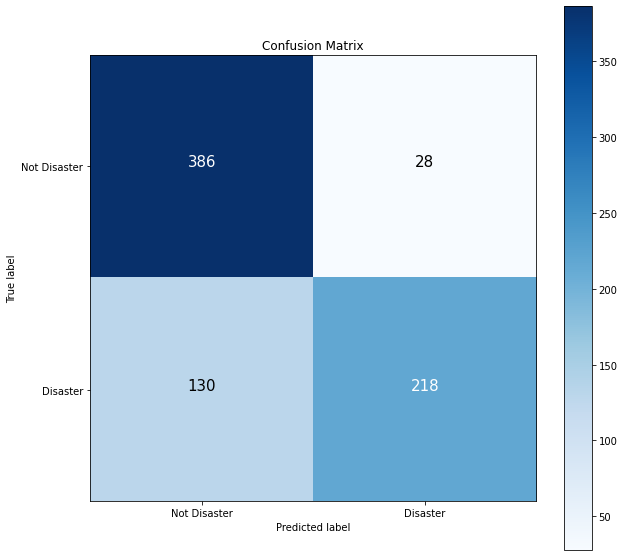

In [45]:
baseline_results = evaluate_predictions(val_labels, baseline_preds)

### Model 1: Feed-forward neural network (dense model)


In [28]:
# Create a tensorboard callback (need to create a new one for each model)

from extras.helper_functions import create_tensorboard_callback

# Create a directory to save Tensorboard logs
SAVE_DIR = "TensorBoard/NLP"

In [68]:
# Build model with the Functional API

inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string)
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # turn numbers into word embeddings
# x = tf.keras.layers.Flatten(name = "flatten_layer")(x)
# x = tf.keras.layers.GlobalMaxPool1D(name = "max_pooling_1d")(x)
x = tf.keras.layers.GlobalAveragePooling1D(name = "global_average_pooling")(x)
outputs = tf.keras.layers.Dense(1, activation = "sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name = 'model_1')

In [69]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling (Glo  (None, 128)              0         
 balAveragePooling1D)                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tra

In [70]:
model_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [71]:
history_model_1 = model_1.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, 'model_1_dense')]
)

Saving TensorBoard log files to: TensorBoard/NLP/model_1_dense/20220713-231825
Epoch 1/5
215/215 [==============================] - 7s 25ms/step - loss: 0.5753 - accuracy: 0.7717 - val_loss: 0.5289 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.4108 - accuracy: 0.8443 - val_loss: 0.4661 - val_accuracy: 0.7940
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.3254 - accuracy: 0.8739 - val_loss: 0.4552 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.2696 - accuracy: 0.9012 - val_loss: 0.4654 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 5s 21ms/step - loss: 0.2280 - accuracy: 0.9183 - val_loss: 0.4829 - val_accuracy: 0.7835


In [74]:
results_model_1 = model_1.evaluate(val_sentences, val_labels)
results_model_1

24/24 [==============================] - 0s 13ms/step - loss: 0.4829 - accuracy: 0.7835


[0.48294728994369507, 0.7834645509719849]

In [75]:
model_preds = model_1.predict(val_sentences)
model_preds.shape

24/24 [==============================] - 0s 9ms/step


(762, 1)

In [78]:
pred_logits = tf.squeeze(tf.round(model_preds))
pred_logits[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

Accuracy: 0.7834645669291339
Precision: 0.8144329896907216
Recall: 0.6810344827586207
F1-Score: 0.7417840375586854


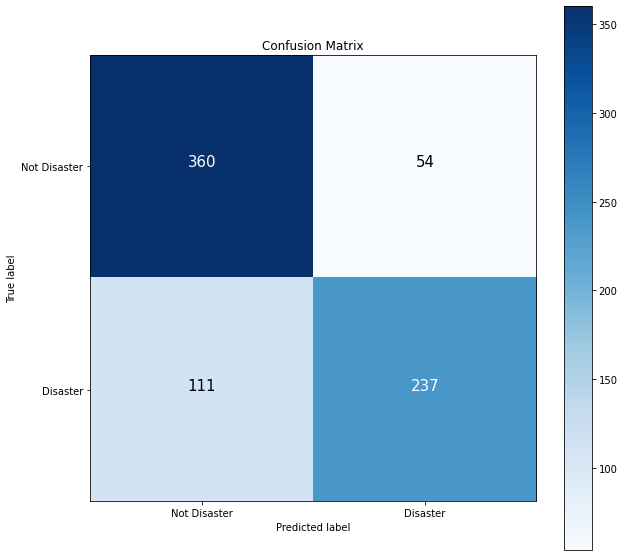

In [80]:
model_1_results = evaluate_predictions(val_labels, pred_logits)

## Visualising model's learned embeddings

In [81]:
# Get the vocabulary from the text vectorization layer
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [88]:
# Get the weight matrix of embedding layer
# (these are the numerical representation of each token in our training data, which have been learned for ~5 epochs)

embed_weights = model_1.get_layer('embedding_1').get_weights()[0]
embed_weights.shape

(10000, 128)

Now we've got the embedding matirx our model has learned to represent our tokens. Lets see how we can visualise it.

To do so, TensorFlow has a handy tool called projector: http://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/tutorials/text/word_embeddings

In [90]:
import io

out_v = io.open('Embeddings/vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('Embeddings/metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

<img src="extras/Artifacts/word_embedding_clusters.png"></img>

We can visualise the above embeddings using [TensorFlow Projector](http://projector.tensorflow.org/) and clicking on the "load" button on the left hand side

📖Resources: For more on word embeddings, refer to:
* Jay Alammar's visualised word2vec post: https://jalammar.github.io/illustrated-word2vec/
* TensorFlow's Word Embeddings guide: https://www.tensorflow.org/tutorials/text/word_embeddings

## Recurrent Neural Networks (RNNs)

RNNs are useful for sequence data

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input

If you want an overview of the internals of a recurrent neural network, see the following:

- MIT's [sequence modelling lecture](https://youtu.be/qjrad0v0uJE)
- Chris Olah's [intro to LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- Andrej Karpathy's [the unreasonable effectiveness of recurrent neural networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

<img src="extras/Artifacts/RNN.png"></img>

### Model 2: LSTM

LSTM -> long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:
```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [22]:
# Create an LSTM model
inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "input_layer")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = tf.keras.layers.LSTM(64, return_sequences = True)(x) # when you're stacking RNN cells together, you need to set return sequences to True
# print(x.shape)
x = tf.keras.layers.LSTM(64)(x)
# print(x.shape)
# x = tf.keras.layers.Dense(64, activation = "relu")(x)
outputs = tf.keras.layers.Dense(1, activation = "sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name = "model_2")

In [23]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________

In [26]:
# Compile the model
model_2.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_model_2 = model_2.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, 'model_2_lstm')]
)

Saving TensorBoard log files to: TensorBoard/NLP/model_2_lstm/20220714-090544
Epoch 1/5
215/215 [==============================] - 22s 20ms/step - loss: 0.5150 - accuracy: 0.7470 - val_loss: 0.4716 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3203 - accuracy: 0.8682 - val_loss: 0.4546 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2205 - accuracy: 0.9194 - val_loss: 0.5830 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1576 - accuracy: 0.9445 - val_loss: 0.6203 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1106 - accuracy: 0.9610 - val_loss: 0.8965 - val_accuracy: 0.7638


In [28]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 13ms/step


array([[0.0052312 ],
       [0.627887  ],
       [0.99957746],
       [0.05893629],
       [0.00436126],
       [0.9997693 ],
       [0.4368527 ],
       [0.9998927 ],
       [0.9998274 ],
       [0.18053026]], dtype=float32)

In [29]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

Accuracy: 0.7637795275590551
Precision: 0.7763157894736842
Recall: 0.6781609195402298
F1-Score: 0.7239263803680982


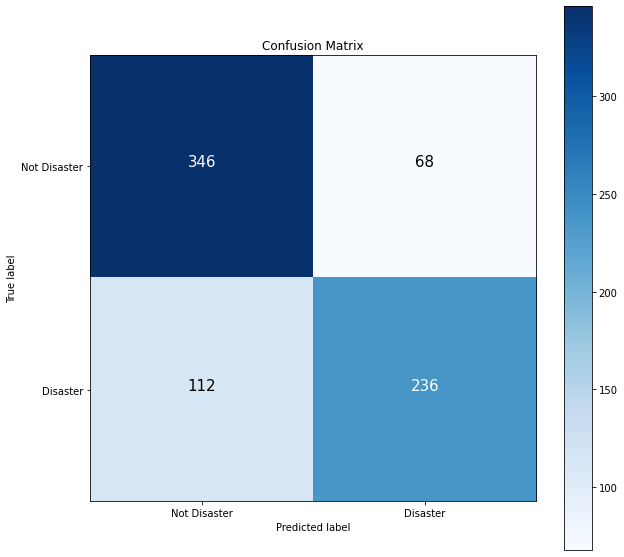

In [32]:
model_2_results = evaluate_predictions(val_labels, model_2_preds)

### Model 3: GRU

GRU -> Gated Recurrent Unit

GRU is similar to LSTM but has less parameters

In [34]:
inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "input_layer")
x = text_vectorizer(inputs)
x = embedding(x)
# x = tf.keras.layers.GRU(64, return_sequences = True)(x) # if you want to stack recurrent layers on top of each other, return sequences needs to be set to true
x = tf.keras.layers.GRU(64)(x)
outputs = tf.keras.layers.Dense(1, activation = "sigmoid", name = "output_layer")(x)

model_3 = tf.keras.Model(inputs, outputs, name = "model_3")

In [35]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________

In [36]:
# Compile the model
model_3.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_model_3 = model_3.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_3_gru")]
)

Saving TensorBoard log files to: TensorBoard/NLP/model_3_gru/20220714-092253
Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.2170 - accuracy: 0.9113 - val_loss: 0.6230 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1037 - accuracy: 0.9651 - val_loss: 0.7452 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0818 - accuracy: 0.9691 - val_loss: 1.0100 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0667 - accuracy: 0.9727 - val_loss: 0.9849 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0552 - accuracy: 0.9772 - val_loss: 1.1426 - val_accuracy: 0.7585


In [37]:
model_3_pred_probs = model_3.predict(val_sentences)

24/24 [==============================] - 1s 12ms/step


In [38]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

Accuracy: 0.7585301837270341
Precision: 0.731638418079096
Recall: 0.7442528735632183
F1-Score: 0.7378917378917379


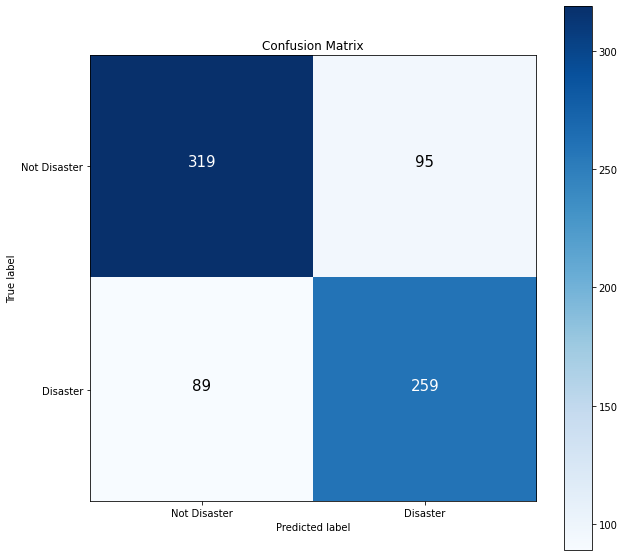

In [39]:
model_3_results = evaluate_predictions(val_labels, model_3_preds)

### Model 4: Bidirectional RNN Model

Normal RNNs go from left to right (just like you'd read English). However, a bidirectional RNN goes from right to left as well as left to right

In [49]:
inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "input_layer")
x = text_vectorizer(inputs)
x = embedding(x)
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
outputs = tf.keras.layers.Dense(1, activation = "sigmoid", name = "output_layer")(x)

model_4 = tf.keras.Model(inputs, outputs, name = "model_4")

In [50]:
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-tra

In [51]:
# Compile the model
model_4.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_model_4 = model_4.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_4_bidirectional")]
)

Saving TensorBoard log files to: TensorBoard/NLP/model_4_bidirectional/20220714-100708
Epoch 1/5
215/215 [==============================] - 10s 24ms/step - loss: 0.1108 - accuracy: 0.9670 - val_loss: 0.9678 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0431 - accuracy: 0.9800 - val_loss: 1.1874 - val_accuracy: 0.7572
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0394 - accuracy: 0.9810 - val_loss: 1.1014 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0396 - accuracy: 0.9807 - val_loss: 1.5808 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0356 - accuracy: 0.9818 - val_loss: 1.3812 - val_accuracy: 0.7572


In [52]:
model_4_pred_probs = model_4.predict(val_sentences)

24/24 [==============================] - 1s 12ms/step


In [53]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

Accuracy: 0.7572178477690289
Precision: 0.7587301587301587
Recall: 0.6867816091954023
F1-Score: 0.7209653092006033


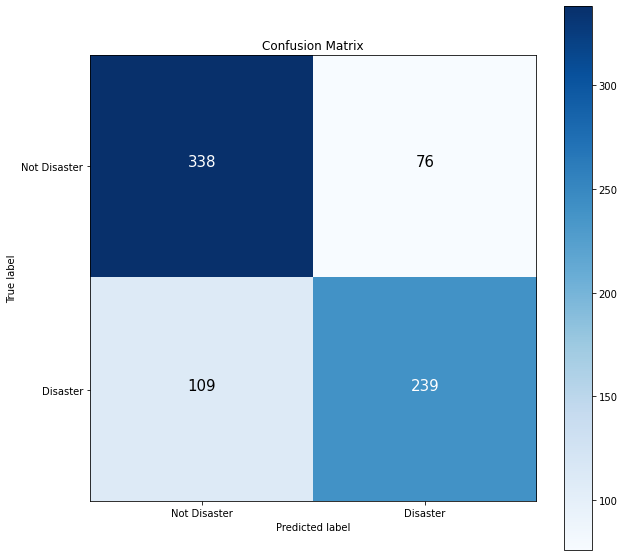

In [54]:
model_4_results = evaluate_predictions(val_labels, model_4_preds)

|Name|When to Use|Learn More|Code|
|----|-----------|----------|----|
|LSTM (long short-term memory)|Default RNN layer for sequence problems|Understanding LSTM Networks by Chris Olah|`tf.keras.layers.LSTM`|
|GRU (gated recurrent unit)|Performs very similar to LSTM (could be used as a default)|Illustrated Guide to LSTMs and GRUs by Michael Phi|`tf.keras.layers.GRU`|
|Bidirectional LSTM (goes forward and backwards on sequence)|Good for sequences which may benefit from passing forward and backwards (eg translation or longer passages of text)|Same as above|`tf.keras.layers.Bidirectional`|

## Convolutional Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width). However, our text data is 1D.

Previously we've used Conv2D for our image data but now we're going to use Conv1D

The typical structure of a Conv1D model for sequences (in our case, text)

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

In [57]:
inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "input_layer")
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(64, 3, activation = "relu", padding = "valid")(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation = "sigmoid", name = "output_layer")(x)

model_5 = tf.keras.Model(inputs, outputs, name = "model_5")

In [58]:
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 64)            24640     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 output_layer (Dense)        (None, 1)                 65  

In [59]:
# Compile the model
model_5.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_model_5 = model_5.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_5_conv1d")]
)

Saving TensorBoard log files to: TensorBoard/NLP/model_5_conv1d/20220714-102819
Epoch 1/5
215/215 [==============================] - 9s 9ms/step - loss: 0.1996 - accuracy: 0.9482 - val_loss: 0.7500 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0932 - accuracy: 0.9648 - val_loss: 0.9426 - val_accuracy: 0.7493
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0691 - accuracy: 0.9714 - val_loss: 1.0909 - val_accuracy: 0.7546
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0598 - accuracy: 0.9756 - val_loss: 1.2014 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0529 - accuracy: 0.9777 - val_loss: 1.2978 - val_accuracy: 0.7467


In [60]:
model_5_pred_probs = model_5.predict(val_sentences)

24/24 [==============================] - 0s 11ms/step


In [61]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

Accuracy: 0.7467191601049868
Precision: 0.739938080495356
Recall: 0.6867816091954023
F1-Score: 0.7123695976154993


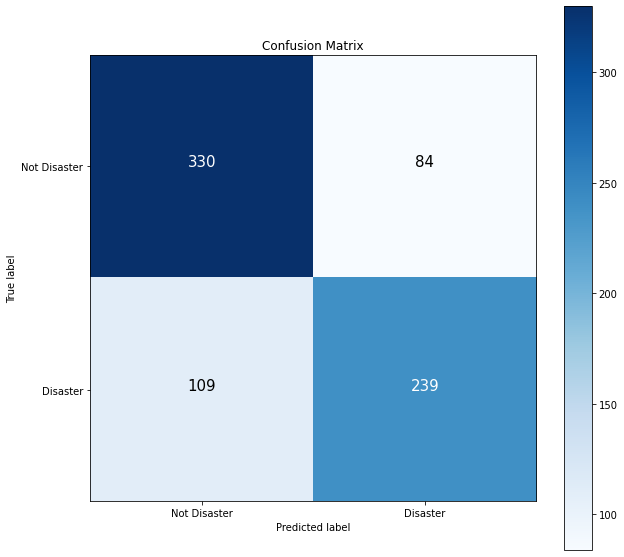

In [62]:
model_5_results = evaluate_predictions(val_labels, model_5_preds)

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, lets try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

Model we're building -> USE feature extractor [Universal Sentence Encoder]

```
Input -> Embedding Layer (USE from Tensorflow Hub) -> Dense (layers) -> Output
```

In [29]:
import tensorflow_hub as hub

embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed_samples = embed([sample_sentence, "When you can the universal sentence encoder on a sentence, it turns it into numbers"])
print(embed_samples)

tf.Tensor(
[[-0.01157027  0.0248591   0.02878048 ... -0.00186125  0.02315824
  -0.01485021]
 [ 0.03485874 -0.08845595 -0.01677877 ... -0.02750706  0.03230239
  -0.00820087]], shape=(2, 512), dtype=float32)


In [30]:
embed_samples[0].shape

TensorShape([512])

In [32]:
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', input_shape = [], dtype = tf.string, trainable = False, name = "USE")

model_6 = tf.keras.Sequential(
    [
        sentence_encoder_layer,
        tf.keras.layers.Dense(1, activation = "sigmoid", name = "output_layer")
    ], name = "model_6"
)

In [33]:
# Compile the model
model_6.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_model_6 = model_6.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_6_USE")]
)

Saving TensorBoard log files to: TensorBoard/NLP/model_6_USE/20220714-141026
Epoch 1/5
215/215 [==============================] - 12s 38ms/step - loss: 0.6502 - accuracy: 0.7341 - val_loss: 0.6144 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 7s 34ms/step - loss: 0.5819 - accuracy: 0.7901 - val_loss: 0.5641 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 7s 34ms/step - loss: 0.5384 - accuracy: 0.7958 - val_loss: 0.5316 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 7s 32ms/step - loss: 0.5094 - accuracy: 0.7974 - val_loss: 0.5104 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 7s 32ms/step - loss: 0.4894 - accuracy: 0.7999 - val_loss: 0.4959 - val_accuracy: 0.7874


In [34]:
model_6_pred_probs = model_6.predict(val_sentences)

24/24 [==============================] - 1s 30ms/step


In [35]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

Accuracy: 0.7874015748031497
Precision: 0.790625
Recall: 0.7270114942528736
F1-Score: 0.7574850299401198


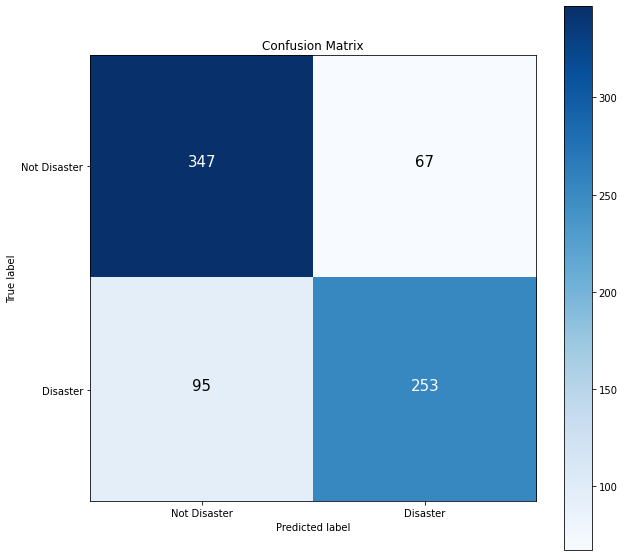

In [36]:
results_model_6 = evaluate_predictions(val_labels, model_6_preds)

Beat the baseline!

## Model 7: Adding another Dense layer to USE

In [62]:
model_7 = tf.keras.Sequential(
    [
        sentence_encoder_layer,
        tf.keras.layers.Dense(64, activation = "relu", name = "prefinal_dense_layer"),
        tf.keras.layers.Dense(1, activation = "sigmoid", name = "output_layer")
    ], name = "model_7"
)

In [63]:
# Compile the model
model_7.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_model_7 = model_7.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, 'model_7_USE_dense')]
)

Saving TensorBoard log files to: TensorBoard/NLP/model_7_USE_dense/20220714-155317
Epoch 1/5
215/215 [==============================] - 9s 34ms/step - loss: 0.5075 - accuracy: 0.7705 - val_loss: 0.4413 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 6s 30ms/step - loss: 0.4148 - accuracy: 0.8146 - val_loss: 0.4382 - val_accuracy: 0.8031
Epoch 3/5
215/215 [==============================] - 6s 28ms/step - loss: 0.3993 - accuracy: 0.8257 - val_loss: 0.4289 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 0.3919 - accuracy: 0.8273 - val_loss: 0.4253 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 6s 26ms/step - loss: 0.3846 - accuracy: 0.8302 - val_loss: 0.4238 - val_accuracy: 0.8163


In [64]:
model_7_pred_probs = model_7.predict(val_sentences)

24/24 [==============================] - 1s 21ms/step


In [65]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

Accuracy: 0.8162729658792651
Precision: 0.8333333333333334
Recall: 0.7471264367816092
F1-Score: 0.787878787878788


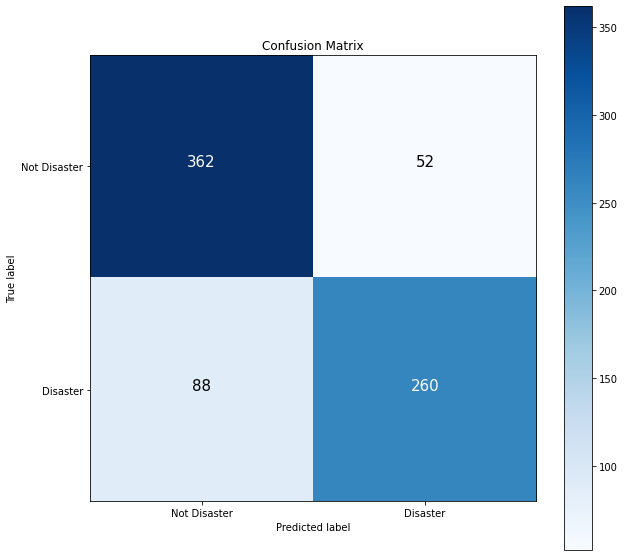

In [66]:
results_model_7 = evaluate_predictions(val_labels, model_7_preds)

We've finally beat the baseline!

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` but with 10% of the data

In [44]:
# Create subsets of 10% of the training data
# NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_7 trained on full data)
# DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

train_10_percent = train_df_shuffled[["text","target"]].sample(frac = 0.1, random_state = 42)
train_10_percent.head()

,text,target
4955,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0
584,FedEx no longer to transport bioterror germs i...,0
7411,Gunmen kill four in El Salvador bus attack: Su...,1
5950,@camilacabello97 Internally and externally scr...,1
5541,Radiation emergency #preparedness starts with ...,1


In [46]:
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()

In [50]:
train_10_percent.target.value_counts()/train_10_percent.target.value_counts().sum()

0    0.542707
1    0.457293
Name: target, dtype: float64

In [51]:
train_df_shuffled.target.value_counts()/train_df_shuffled.target.value_counts().sum()

0    0.57034
1    0.42966
Name: target, dtype: float64

So the distribution is more or less similar!

Now lets use the same model we had and just train that on 10% data

In [52]:
model_7 = tf.keras.models.clone_model(model_7)

# Compile the model
model_7.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_model_7_mod = model_7.fit(
    x = train_sentences_10_percent,
    y = train_labels_10_percent,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_7_10_pct_USE")]
)

Saving TensorBoard log files to: TensorBoard/NLP/model_7_10_pct_USE/20220714-144829
Epoch 1/5
24/24 [==============================] - 4s 63ms/step - loss: 0.6672 - accuracy: 0.7227 - val_loss: 0.6260 - val_accuracy: 0.8123
Epoch 2/5
24/24 [==============================] - 1s 35ms/step - loss: 0.5921 - accuracy: 0.7989 - val_loss: 0.5448 - val_accuracy: 0.8018
Epoch 3/5
24/24 [==============================] - 1s 40ms/step - loss: 0.5178 - accuracy: 0.8016 - val_loss: 0.4779 - val_accuracy: 0.8084
Epoch 4/5
24/24 [==============================] - 1s 37ms/step - loss: 0.4623 - accuracy: 0.8029 - val_loss: 0.4361 - val_accuracy: 0.8163
Epoch 5/5
24/24 [==============================] - 1s 36ms/step - loss: 0.4261 - accuracy: 0.8187 - val_loss: 0.4062 - val_accuracy: 0.8307


24/24 [==============================] - 1s 19ms/step
Accuracy: 0.8307086614173228
Precision: 0.8308157099697885
Recall: 0.7902298850574713
F1-Score: 0.8100147275405007


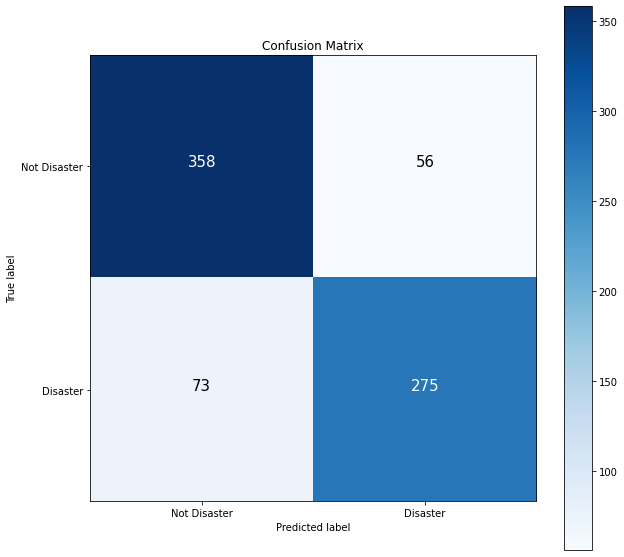

In [53]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
results_model_7_10_pct = evaluate_predictions(val_labels, model_7_preds)

Thats strange! A model trained on a tenth of the data performs better than a model trained with full data!

And you know what! Its precisely that. Since the validation data was created with `random_state` set to 42 and our train data is also created with the same value for `random_state`, there's going to be a huge overlap between the two. How to check for this you ask? The next code cell will do precisely this.

In [54]:
overlap_sent = 0
for sentence in train_sentences_10_percent:
    if sentence in val_sentences:
        overlap_sent += 1

print(f'Number of overlapping sentences: {overlap_sent}/{len(train_sentences_10_percent)}')

Number of overlapping sentences: 761/761


What the fish! The train and validation data are exactly the same. No wonder we're getting such wonderful accuracy numbers.

In [58]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [59]:
pd.Series(train_labels_10_percent).value_counts()/pd.Series(train_labels_10_percent).value_counts().sum()

0    0.592701
1    0.407299
dtype: float64

Yeah so this might just work since the distribution isn't altered significantly

In [60]:
model_7 = tf.keras.models.clone_model(model_7)

# Compile the model
model_7.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_model_7_fixed_data = model_7.fit(
    x = train_sentences_10_percent,
    y = train_labels_10_percent,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_7_10_pct_fixed_data_USE")]
)

Saving TensorBoard log files to: TensorBoard/NLP/model_7_10_pct_fixed_data_USE/20220714-151119
Epoch 1/5
22/22 [==============================] - 4s 78ms/step - loss: 0.6622 - accuracy: 0.7314 - val_loss: 0.6413 - val_accuracy: 0.7428
Epoch 2/5
22/22 [==============================] - 1s 41ms/step - loss: 0.5865 - accuracy: 0.8058 - val_loss: 0.5803 - val_accuracy: 0.7690
Epoch 3/5
22/22 [==============================] - 1s 45ms/step - loss: 0.5089 - accuracy: 0.8277 - val_loss: 0.5301 - val_accuracy: 0.7717
Epoch 4/5
22/22 [==============================] - 1s 42ms/step - loss: 0.4544 - accuracy: 0.8248 - val_loss: 0.5020 - val_accuracy: 0.7769
Epoch 5/5
22/22 [==============================] - 1s 42ms/step - loss: 0.4150 - accuracy: 0.8423 - val_loss: 0.4930 - val_accuracy: 0.7795


24/24 [==============================] - 1s 21ms/step
Accuracy: 0.7795275590551181
Precision: 0.7960526315789473
Recall: 0.6954022988505747
F1-Score: 0.7423312883435583


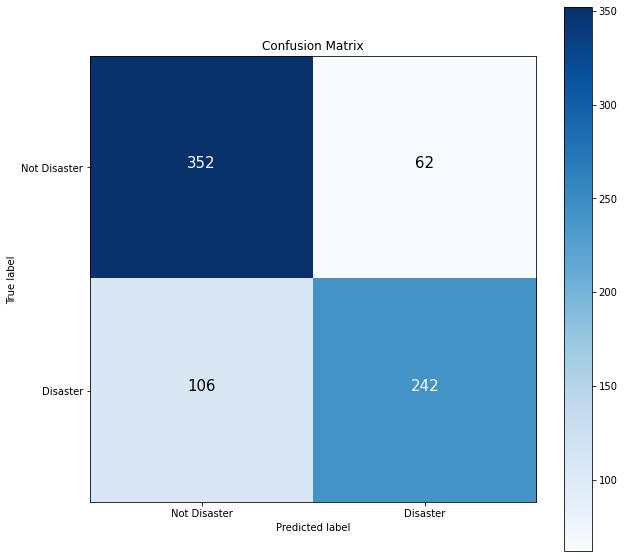

In [61]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
results_model_7_10_pct_fixed_data = evaluate_predictions(val_labels, model_7_preds)

Ooowie! This seems decent for the kind of training data its seen.

> 🔑**Note:** Be very careful when creating training/validation/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data), trust your gut and go back through to find where the error may lie

## Comparing the performance of each of our models

In [ ]:
# Combine model results into a DataFrame

# all_model_results = pd.DataFrame({"0_baseline": baseline_results,
#                                  "1_simple_dense": model_1_results,
#                                  "2_lstm": model_2_results,
#                                  "3_gru": model_3_results,
#                                  "4_bidirectional": model_4_results,
#                                  "5_conv1d": model_5_results,
#                                  "6_USE": model_6_results,
#                                  "7_USE_10_percent": model_7_results})

# all_model_results.transpose()

In [ ]:
# Plot and compare all of the model results
# all_model_results.plot(kind = "bar", figsize = (10, 7).legend(bbox_to_anchor = (1.0, 1.0)));

In [ ]:
# Sort model results by f1-score
# all_model_results.sort_values("f1", ascending = False)["f1"].plot(kind = "bar", figsize = (10, 7));

## Comparing our Models Using TensorBoard

In [ ]:
# !tensorboard dev upload --logdir "TensorBoard/NLP" \
    # --name "NLP Modelling Experiments" \
    # --description "Comparing different experiments on TensorBoard" \
    # --one_shot

In [ ]:
# !tensorboard dev list

In [ ]:
# !tensorboard dev delete --experiment_id ....

## Saving and Loading a Trained Model
There are 2 main formats to save a model in TensorFlow:
1. The HDF-5 format
2. The SavedModel format

In [67]:
model_7.save("Models/NLP/best_model.h5")

In [70]:
# Load model with custom Hub Layer (required HDF5 format)
# import tensorflow_hub as hub

# loaded_model_7 = tf.keras.models.load_model("Models/NLP/best_model.h5", custom_objects={"KerasLayer": hub.KerasLayer})

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those with prediction probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa

In [1]:
# Download a pretrained model from Google Storage
!curl "https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip" --output "Models/NLP/08_model_6_USE_feature_extractor.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  916M    0  3338    0     0   2676      0 99:43:55  0:00:01 99:43:54  2678
  0  916M    0 3086k    0     0  1918k      0  0:08:08  0:00:01  0:08:07 1919k
  1  916M    1 9808k    0     0  3757k      0  0:04:09  0:00:02  0:04:07 3757k
  2  916M    2 18.5M    0     0  5267k      0  0:02:58  0:00:03  0:02:55 5268k
  3  916M    3 28.1M    0     0  6259k      0  0:02:29  0:00:04  0:02:25 6260k
  4  916M    4 38.5M    0     0  7043k      0  0:02:13  0:00:05  0:02:08 9055k
  5  916M    5 49.0M    0     0  7595k      0  0:02:03  0:00:06  0:01:57 9422k
  6  916M    6 60.0M    0     0  8081k      0  0:01:56  0:00:07  0:01:49 10.0M
  7  916M    7 68.0M    0     0  8096k      0  0:01:55  0:00:08  0:01:47  9.9M
  8  916M    8 75.9M    0     0  8093k      0  0:01

In [2]:
from zipfile import ZipFile
zip_file = ZipFile("Models/NLP/08_model_6_USE_feature_extractor.zip")
zip_file.extractall("Models/NLP")
zip_file.close()

In [10]:
# Import previously trained model
model_6_pretrained = tf.keras.models.load_model("Models/NLP/08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 5s 37ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [11]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 1s 26ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [12]:
# Create DataFrame with validation sentences and best performing model predictions
val_df = pd.DataFrame({
    "text": val_sentences,
    "target": val_labels,
    "pred": model_6_pretrained_preds,
    "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)
})

val_df

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.137074
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.095865
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
760,Crack in the path where I wiped out this morni...,0,1.0,0.612631


In [31]:
false_preds_df = val_df[val_df.target != val_df.pred].sort_values(by = "pred_prob", ascending = False)

In [32]:
false_preds_df

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
...,...,...,...,...
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949


In [34]:
for row in false_preds_df[:10].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
    print(f'Text:\n{text}\n')
    print('----\n')

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523000478744507
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354543447494507
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [35]:
for row in false_preds_df[-10:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
    print(f'Text:\n{text}\n')
    print('----\n')

Target: 1, Pred: 0.0, Prob: 0.06730347871780396
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.05507579818367958
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.05460338667035103
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.054596975445747375
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.049637261778116226
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0

## Making predictions on the test dataset

In [37]:
import random
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
    pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
    pred = tf.round(pred_prob)
    print(f'Pred: {int(pred)}, Prob: {pred_prob}')
    print(f'Text:\n{test_sample}\n')
    print('-----\n')

1/1 [==============================] - 0s 102ms/step
Pred: 0, Prob: 0.11294429749250412
Text:
Not an electric debut for Severino but not a disaster either. Looking forward to see what adjustments he makes for start #2.

-----

1/1 [==============================] - 0s 86ms/step
Pred: 0, Prob: 0.35183560848236084
Text:
I was walking past the fire house today &amp; as soon as I walk by the doors they get call and flip the sirens on. I've never ran so fast.

-----

1/1 [==============================] - 0s 86ms/step
Pred: 1, Prob: 0.5752080678939819
Text:
#Np love police @PhilCollinsFeed On #LateNiteMix Uganda Broadcasting Corporation. UBC 98FM #Radio/ #Uganda / #MbbLive

-----

1/1 [==============================] - 0s 64ms/step
Pred: 1, Prob: 0.9053696990013123
Text:
SH 29 Kaimai Ranges - Eastbound. Hazardous driving conditions. Due To A Truck Breakdown... http://t.co/0cuCMZCmaO via @AA_Traffic

-----

1/1 [==============================] - 0s 98ms/step
Pred: 1, Prob: 0.9283893704414368

## The speed/score tradeoff

In [38]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
    """
    Times how long a model takes to make predictions on samples.
    """
    start_time = time.perf_counter() # get start time
    model.predict(samples) # make predictions
    end_time = time.perf_counter() # get finish time
    total_time = end_time - start_time # calculate how long predictions took to make
    time_per_pred = total_time / len(samples)
    return total_time, time_per_pred

In [39]:
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model = model_6_pretrained, samples = val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 1s 24ms/step


(0.6939992000043276, 0.0009107601049925559)

In [47]:
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model = model_0, samples = val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.026902500001597218, 3.530511811233231e-05)

Accuracy: 0.8162729658792651
Precision: 0.8398692810457516
Recall: 0.7385057471264368
F1-Score: 0.7859327217125381


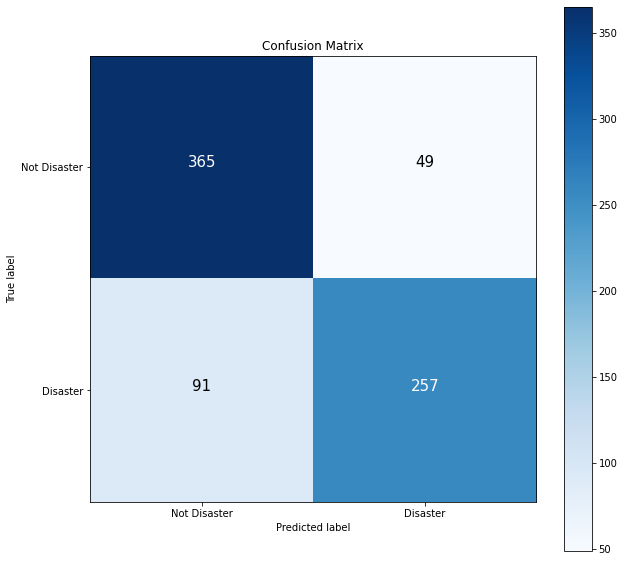

In [48]:
model_6_pretrained_results = evaluate_predictions(val_labels, model_6_pretrained_preds)

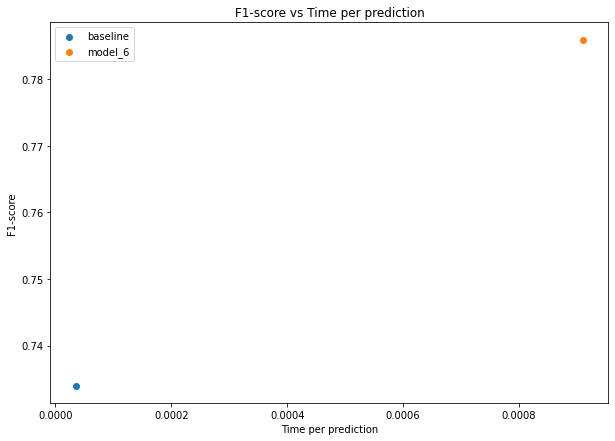

In [50]:
plt.figure(figsize = (10, 7))
plt.scatter(baseline_time_per_pred, baseline_results['F1_Score'], label = "baseline");
plt.scatter(model_6_time_per_pred, model_6_pretrained_results['F1_Score'], label = "model_6");
plt.legend();
plt.title("F1-score vs Time per prediction");
plt.xlabel("Time per prediction");
plt.ylabel("F1-score");